# Univariate regression to predict the wind speed field

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random

from utils.logging_metrics import MetricsLogger
from utils.data_loaders import get_wake_dataloaders
import utils.plotting as plotting
from utils.evaluation import evaluate_model

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [2]:
# hyperparameters
# in univariate, the batch size is a multiplier for number of cells
# (i.e. the batch_size should be dividible by the number of cells)
BATCH_MULTIPLIER = 8
EPOCHS = 500
LR = 0.01

ACTIVATION_FUNCTION = nn.ReLU() #TODO
N_MAPPING = 64  # Number of Fourier features
HIDDEN_LAYERS_UNITS = [128, 256, 32]

FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
#INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 4, 'ct': 4}
#train_reduc_factor_string = "training_factors=" + "-".join([f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()])
INPUT_VAR_TO_TRAIN_RANGES = {'ti': [(0.15, 0.4)], 'ct': [(0.3, 0.7)]}
train_range_string = "training_ranges=" + '-'.join([f"{var}{r[0]}-{r[1]}" for var, ranges in INPUT_VAR_TO_TRAIN_RANGES.items() for r in ranges])
MODEL_NAME = f"univariate_NeRF_{N_MAPPING}fourier-features_"\
    f"layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}_{train_range_string}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
CONSIDER_WS = False
COORDS_AS_INPUT = True # univariate setting
N_COORDINATES = 2  # Number of input coordinates (x and y)
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    FACTORS_FOLDER = FACTORS_FOLDER.replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
print(f"Model name: {MODEL_NAME}")
print(f"Best model path: {BEST_MODEL_PATH}")

MODEL_DESCRIPTION = f"{MODEL_NAME}_{FACTORS_FOLDER}: act. func. {ACTIVATION_FUNCTION.__class__.__name__} " +\
    f"(not last layer), batch multiplier {BATCH_MULTIPLIER}, {EPOCHS} epochs, lr={LR})"
print(f"Model description: {MODEL_DESCRIPTION}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")

Model name: univariate_NeRF_64fourier-features_layers128-256-32_training_ranges=ti0.15-0.4-ct0.3-0.7
Best model path: saved_models/discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01/univariate_NeRF_64fourier-features_layers128-256-32_training_ranges=ti0.15-0.4-ct0.3-0.7.pt
Model description: univariate_NeRF_64fourier-features_layers128-256-32_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=0.01)

Device: cpu


In [3]:
class FourierLayer(nn.Module):
    def __init__(self, n_features: int, n_mapping: int):
        super(FourierLayer, self).__init__()
        self.coefficients = nn.Parameter(torch.randn(n_mapping, n_features))

    def forward(self, x):
        x_proj = 2 * torch.pi * x @ self.coefficients.t()
        out = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return out

class NeRF2D(nn.Module):
    def __init__(self, n_coordinates: int, n_features: int, output_space: int):
        super(NeRF2D, self).__init__()
        self.fourier_layer = FourierLayer(n_coordinates, N_MAPPING)
        layer_units = [N_MAPPING * 2 + n_features] + HIDDEN_LAYERS_UNITS
        mlp_layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            mlp_layers += [nn.Linear(first, second), ACTIVATION_FUNCTION]
        mlp_layers.append(nn.Linear(layer_units[-1], output_space)) # last layer not activated
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, inputs):
        # Pass coordinates through the Fourier Layer
        coords = inputs[:, -2:]
        input_features = inputs[:, :-2]
        fourier_out = self.fourier_layer(coords)

        # Concatenate Fourier layer output with other input features
        input_features = torch.cat((fourier_out, input_features), dim=-1)

        # Feed-forward through the rest of the neural network
        x = self.mlp(input_features)

        return x

In [4]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATA_FOLDER,
                                                          consider_ws=CONSIDER_WS,
                                                          coords_as_input=COORDS_AS_INPUT,
                                                          #train_perc=0.6,
                                                          #test_perc=0.2,
                                                          #validation_perc=0.2,
                                                          input_var_to_train_ranges=INPUT_VAR_TO_TRAIN_RANGES,
                                                          batch_multiplier=BATCH_MULTIPLIER)
len(train_dataloader)
print(valid_dataloader)

/Users/niccolomorabito/Library/CloudStorage/GoogleDrive-morabito.1808746@studenti.uniroma1.it/My Drive/BDMA/Semester4 Thesis/Ainslie-surrogate/utils/data_loaders.py:241: UserWarning: 
Ignoring percentages of train-valid-test split (train_perc=0.8, valid_perc=0, test_perc=0.2)
and using the following ranges for the training set instead:
{'ti': [(0.15, 0.4)], 'ct': [(0.3, 0.7)]}
  warnings.warn(
<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [5]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

input_space = train_dataloader.dataset.inputs.shape[1]
n_features = input_space - N_COORDINATES
output_space = train_dataloader.dataset.outputs.shape[1]
print(f"{input_space=} ({N_COORDINATES} coordinates and {n_features} other input features)\t{output_space=}")

torch.Size([57344, 4]) torch.Size([57344, 1])
input_space=4 (2 coordinates and 2 other input features)	output_space=1


In [6]:
model = NeRF2D(N_COORDINATES, n_features, output_space).to(DEVICE)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=LR
)
loss_function = torch.nn.MSELoss()

metrics_logger = MetricsLogger(name=MODEL_NAME, automatic_save_after=2)
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    model.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()
        prediction = model(x)
        tloss = loss_function(prediction, y)
        tloss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_tloss += tloss.item() * x.size(0)
        #TODO accuracy or other metric computation????

    avg_tloss = epoch_tloss / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss', avg_tloss)

    '''VALIDATION'''
    if valid_dataloader:
        model.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
            prediction = model(x)
            vloss = loss_function(prediction, y)

            epoch_vloss += vloss.item() * x.size(0)

        avg_vloss = epoch_vloss / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss', avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), BEST_MODEL_PATH)

Logging univariate_NeRF_64fourier-features_layers128-256-32_training_ranges=ti0.15-0.4-ct0.3-0.7
Epoch 0 ->	Training loss=0.012207924098127078	Validation loss=0.0007426874888622607	epoch_time (seconds)=226	
Epoch 1 ->	Training loss=0.00011312451283873354	Validation loss=0.0006836983663446826	epoch_time (seconds)=228	
Epoch 2 ->	Training loss=5.44263458993178e-05	Validation loss=0.00045194186546769456	epoch_time (seconds)=264	
Epoch 3 ->	Training loss=1.4660343855744365e-05	Validation loss=0.00038380795626427437	epoch_time (seconds)=242	
Epoch 4 ->	Training loss=8.365055206324054e-06	Validation loss=0.0003691900290153641	epoch_time (seconds)=253	
Epoch 5 ->	Training loss=6.2879188794240916e-06	Validation loss=0.00036149392608451013	epoch_time (seconds)=237	
Epoch 6 ->	Training loss=5.398726071223614e-06	Validation loss=0.0003615386919131372	epoch_time (seconds)=240	
Epoch 7 ->	Training loss=4.974261774783017e-06	Validation loss=0.00035577503428680735	epoch_time (seconds)=238	
Epoch 8 ->

KeyboardInterrupt: 

epoch_time (seconds)=211	

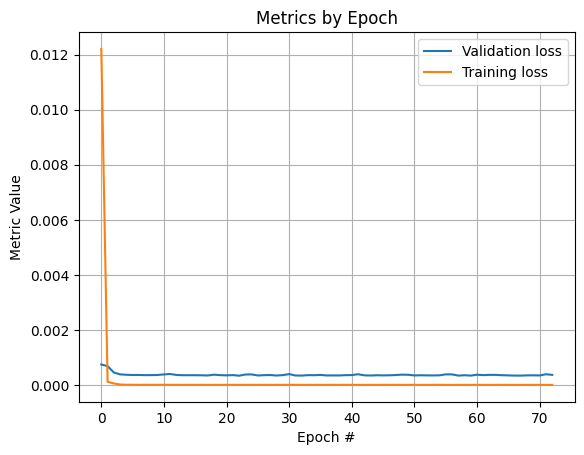

Metrics exported in the following csv file: metrics/logged_metrics/univariate_NeRF_64fourier-features_layers128-256-32_training_ranges=ti0.15-0.4-ct0.3-0.7_07-07-2023_10-33-01.csv


In [7]:
metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

# Evaluation and testing

In [8]:
# loading best model
model = NeRF2D(N_COORDINATES, n_features, output_space).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

# evaluation on trainset
evaluate_model(model, data=train_dataloader, data_type='train',
               model_description=MODEL_DESCRIPTION,
               save_results=True)

print("\n")

# evalution on testset
evaluate_model(model, data=test_dataloader, data_type='test',
               model_description=MODEL_DESCRIPTION,
               save_results=True)

Train results for univariate_NeRF_64fourier-features_layers128-256-32_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=0.01)
r2_score=0.9856521291716728
explained_variance_score=0.9905099272727966
mean_squared_error=1.3037709322816227e-05
mean_absolute_error=0.0021208736579865217
median_absolute_error=0.0015383330173790455
mean_absolute_percentage_error=31.672719955444336
Prediction time=8.076097984970239e-06s


Test results for univariate_NeRF_64fourier-features_layers128-256-32_training_ranges=ti0.15-0.4-ct0.3-0.7_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 500 epochs, lr=0.01)
r2_score=0.7015981195789418
explained_variance_score=0.7016127109527588
mean_squared_error=0.00034331934875808656
mean_absolute_error=0.008307259529829025
median_absolute_error=0.003577536903321743
mean_absolute_percentage_error

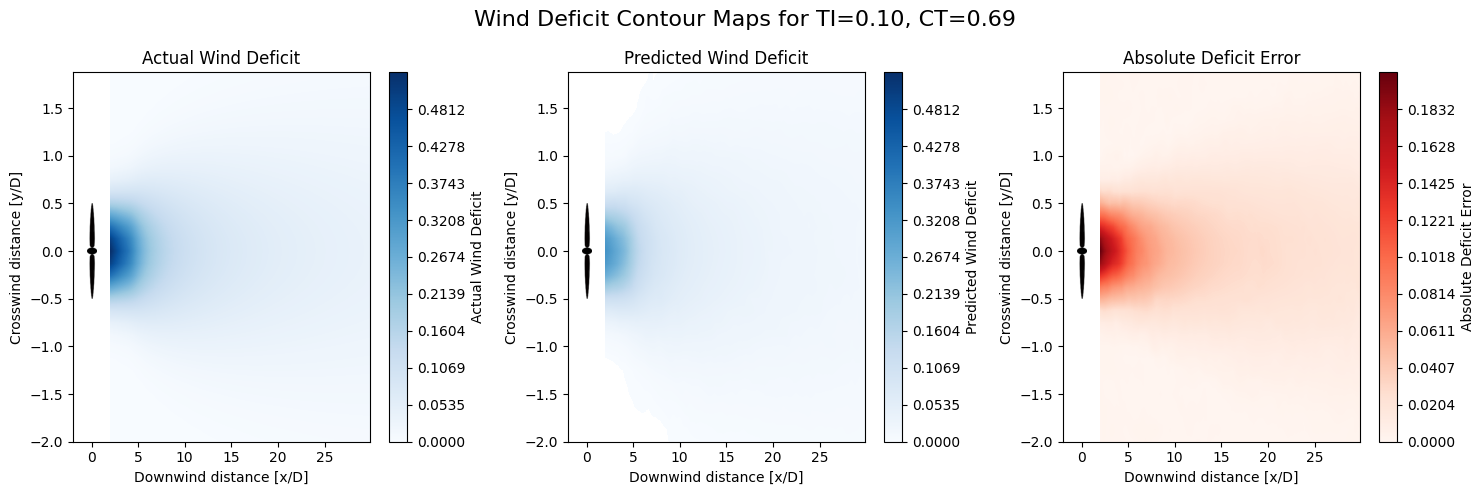

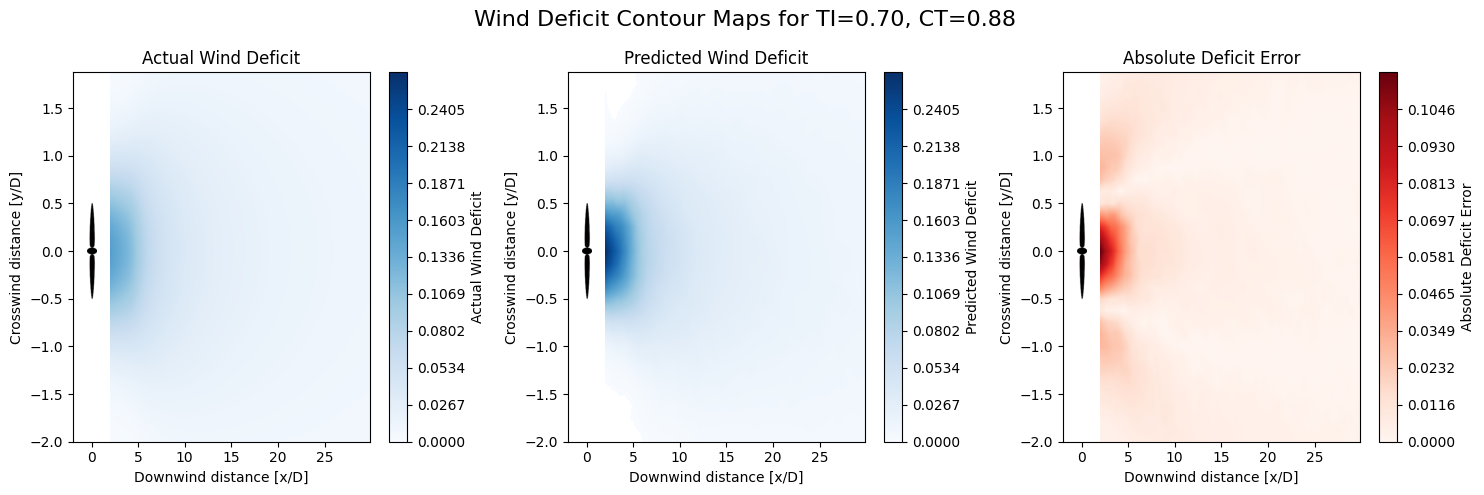

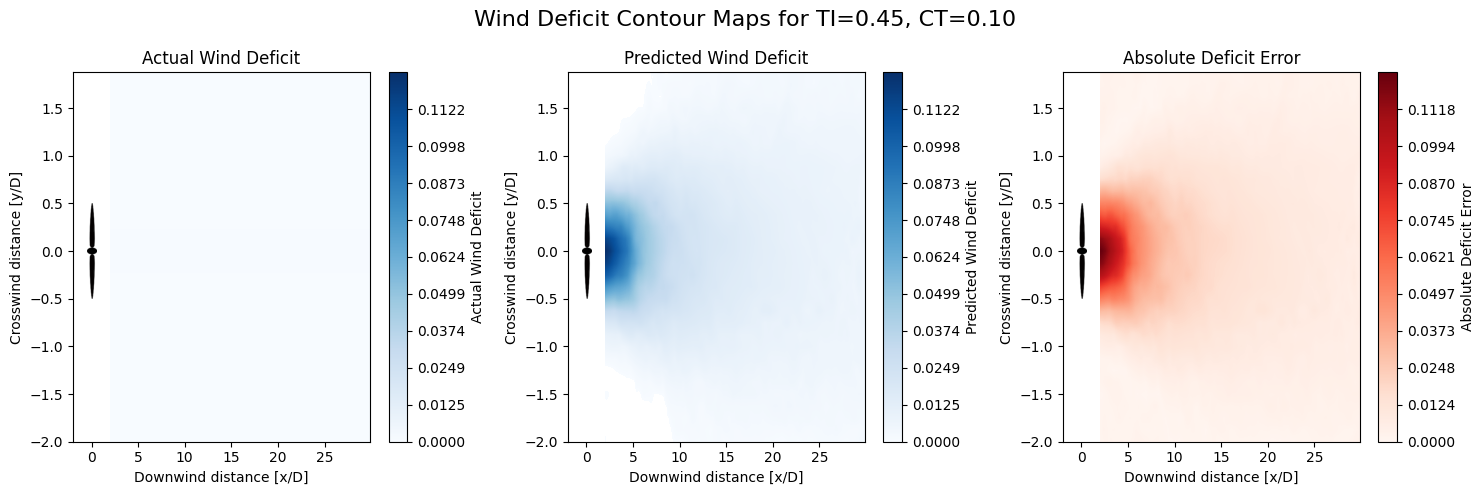

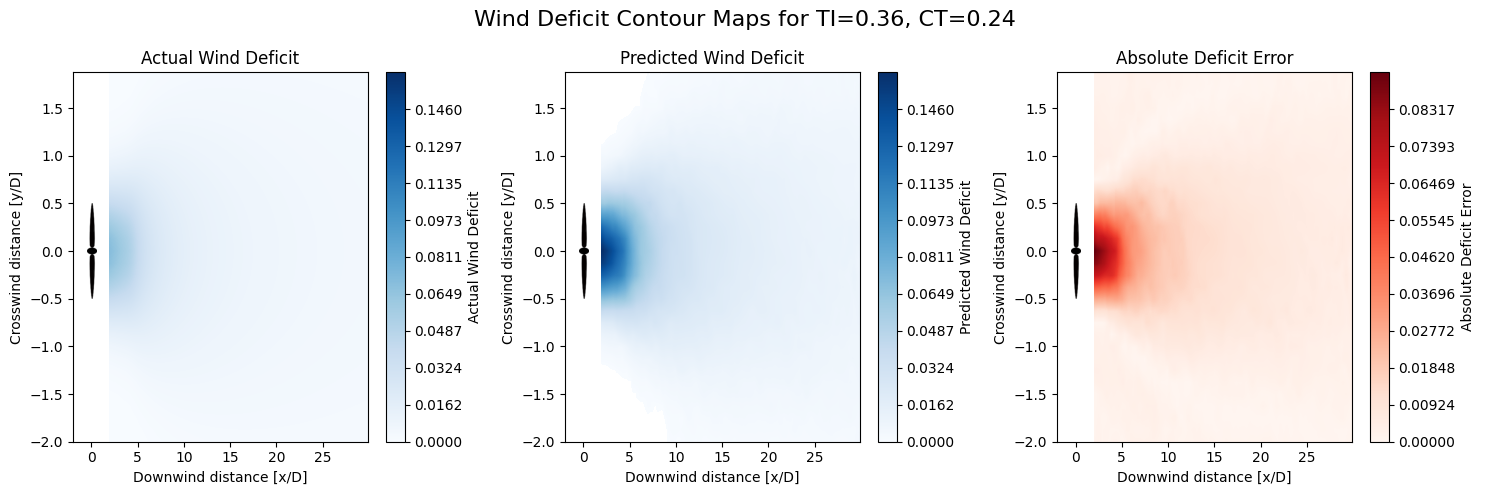

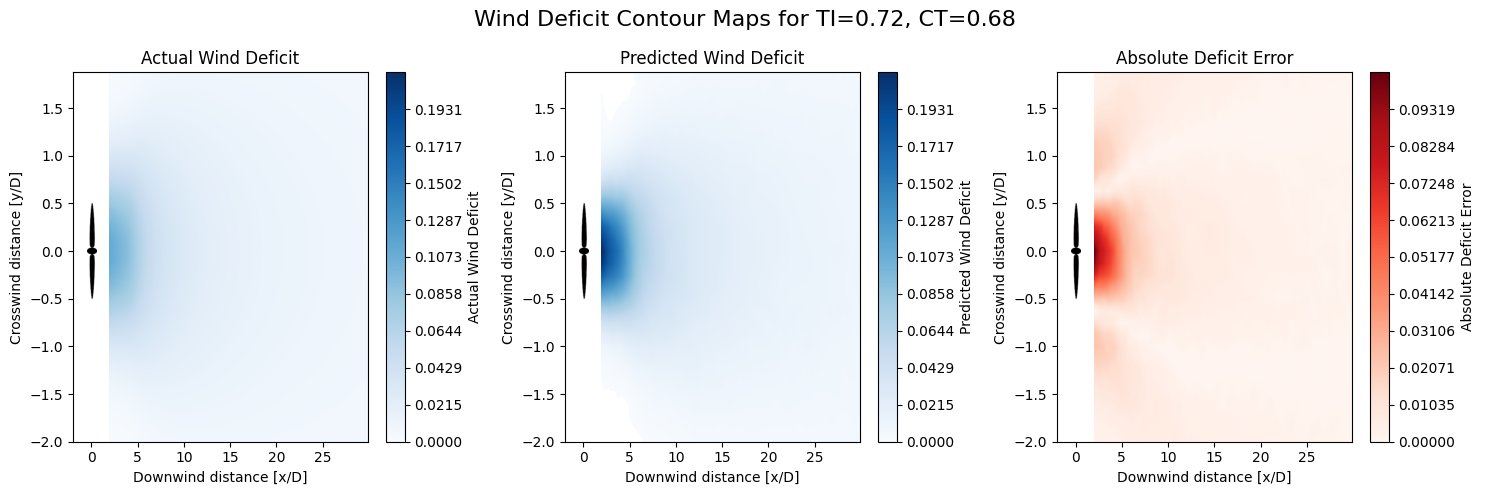

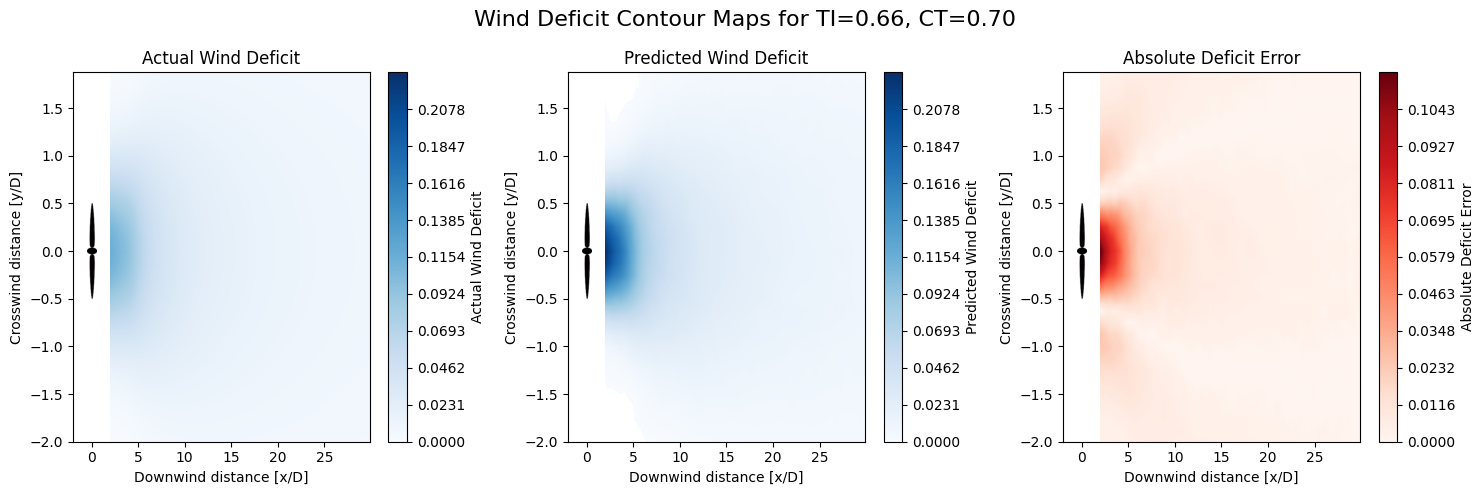

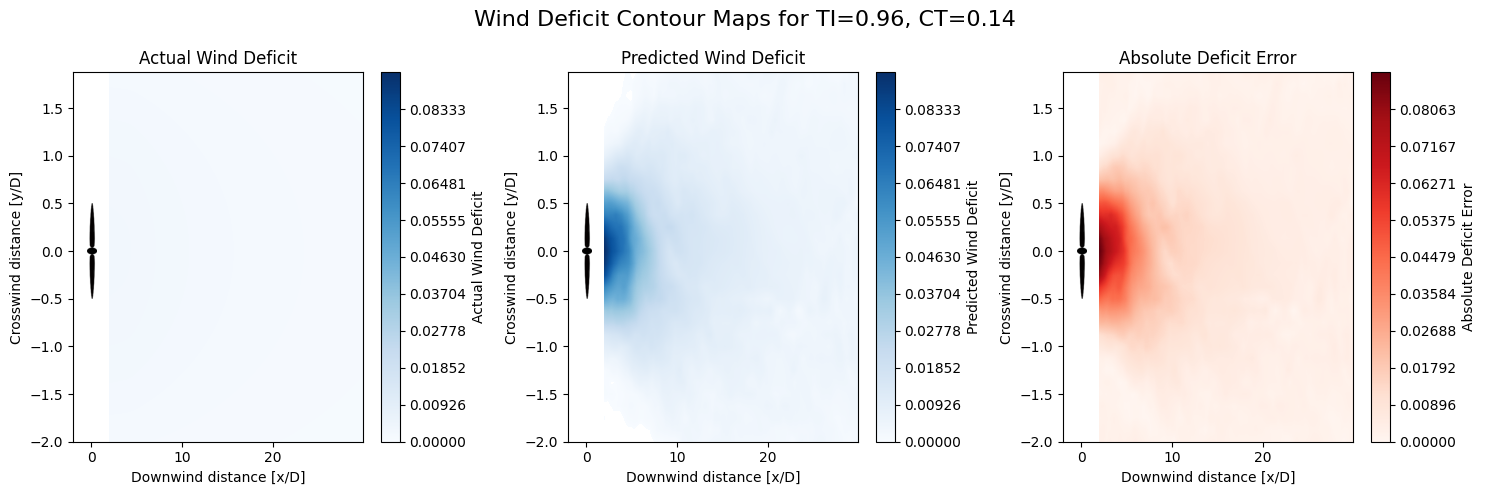

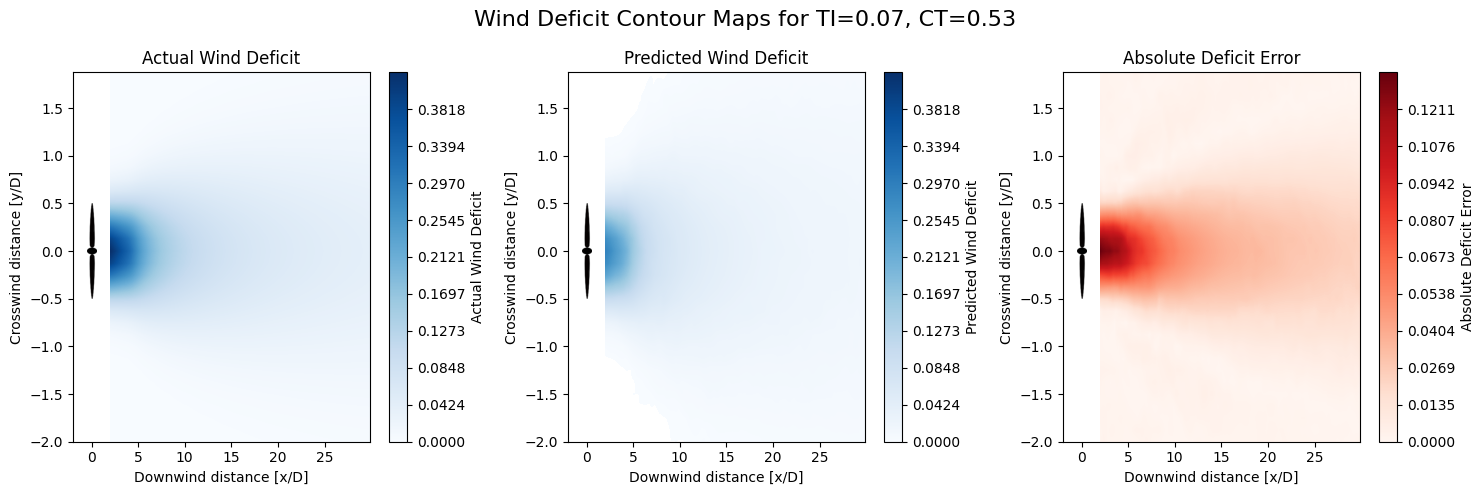

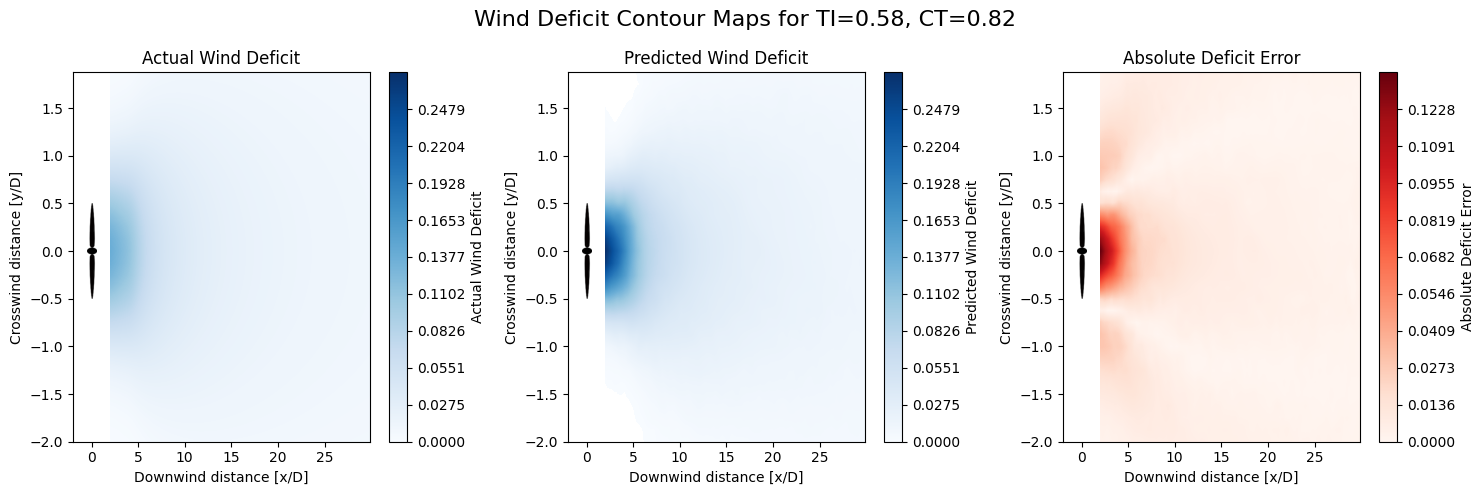

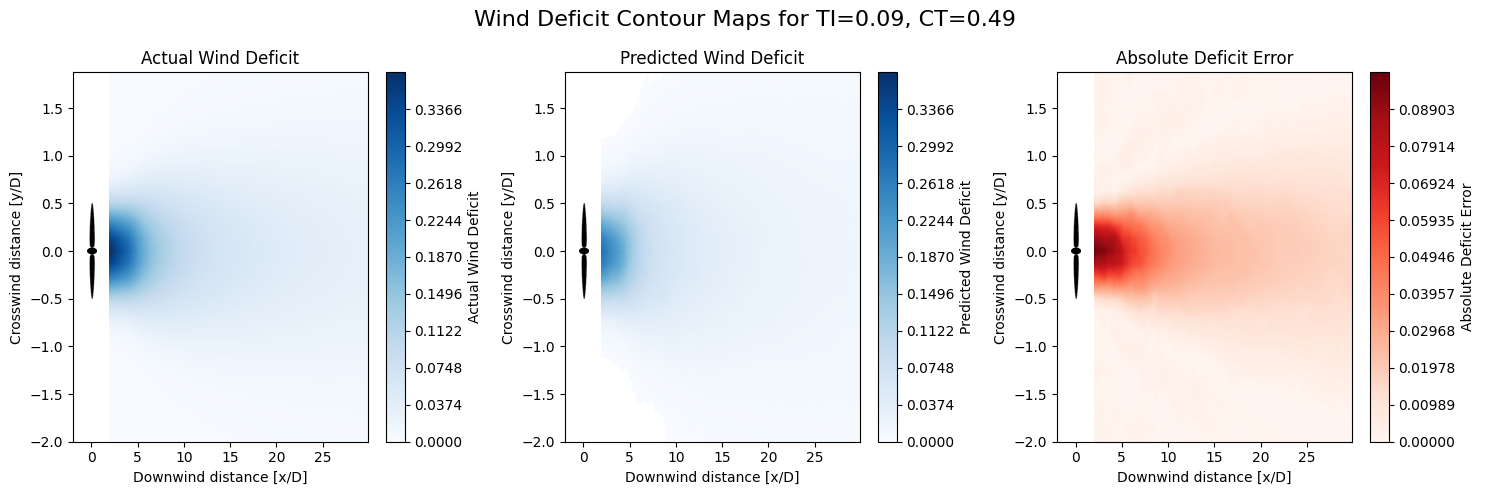

In [9]:
test_dataset = test_dataloader.dataset
num_cells = test_dataset.num_cells
num_fields = len(test_dataset)//num_cells
field_indices = list(range(num_fields))
random.shuffle(field_indices)

with torch.no_grad():
    for field_idx in field_indices[:10]:
        ti, ct, ws, wake_field, predicted_wake_field = test_dataset.get_parameters_for_plotting_univariate(model, field_idx)
        plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')